In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR

inspired by https://github.com/benmoseley/harmonic-oscillator-pinn/blob/main/Harmonic%20oscillator%20PINN.ipynb and
https://github.com/nanditadoloi/PINN/blob/main/solve_PDE_NN.ipynb and https://towardsdatascience.com/solving-differential-equations-with-neural-networks-afdcf7b8bcc4

In [2]:
def oscillator(d, w0, x):
    """Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/"""
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

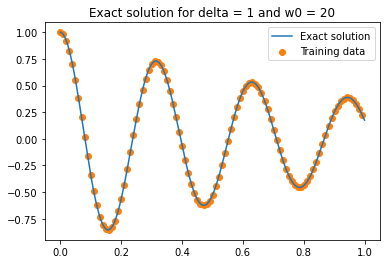

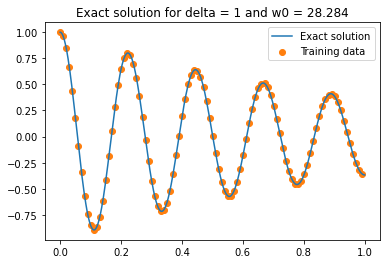

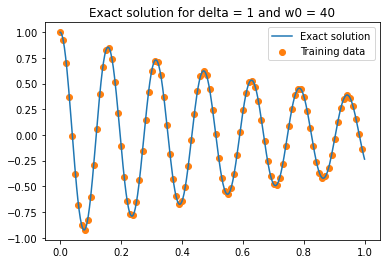

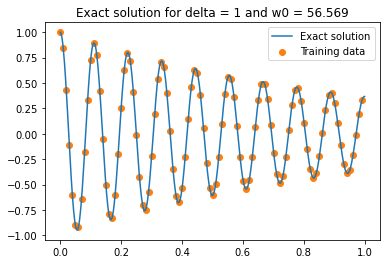

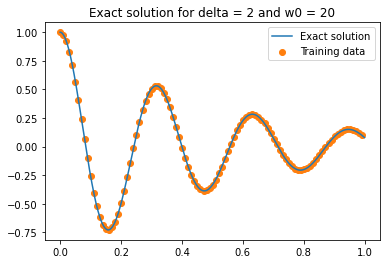

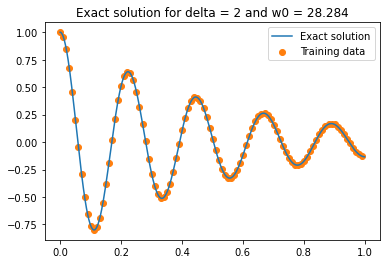

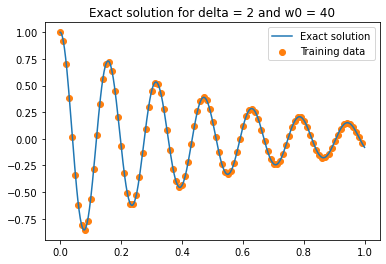

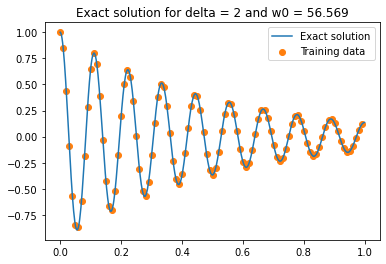

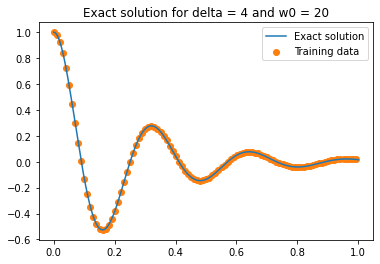

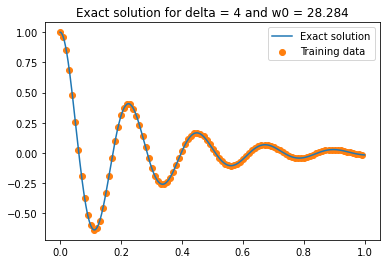

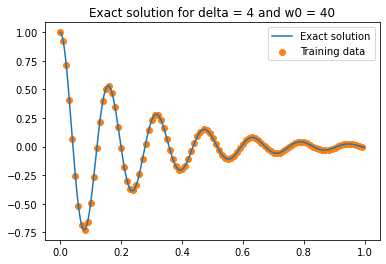

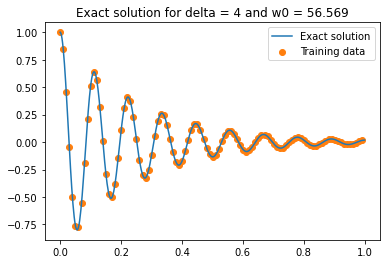

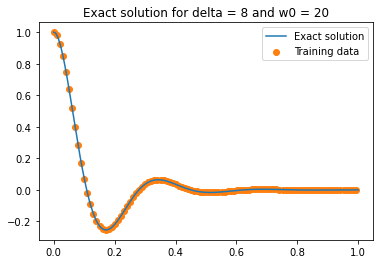

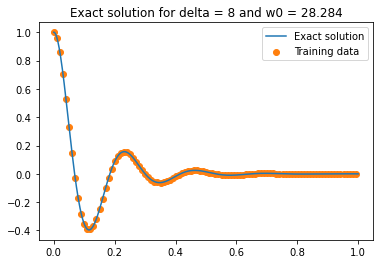

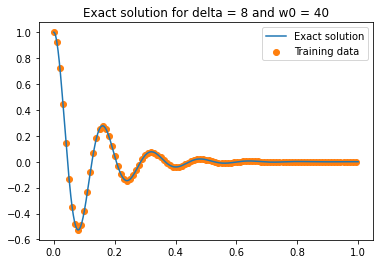

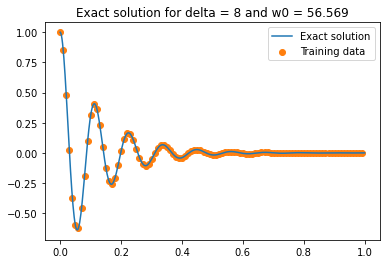

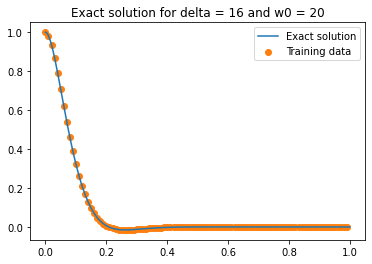

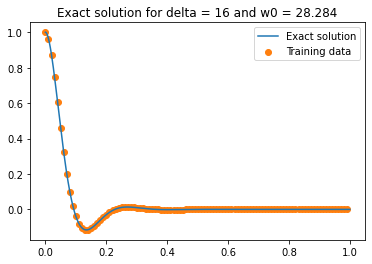

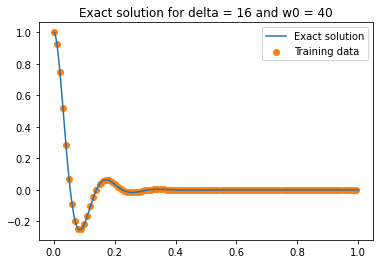

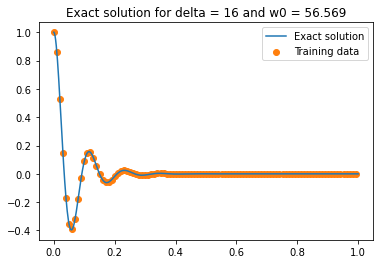

In [6]:
### Generate training and validation data

deltas = [1, 2, 4, 8, 16]
omegas = [20, np.sqrt(800), 40, np.sqrt(3200)]

x_train = []
y_train = []
par_train = []
for d in deltas:
    for w0 in omegas:

        # get the analytical solution over the full domain
        x = torch.linspace(0,1,500).view(-1,1)
        y = oscillator(d, w0, x).view(-1,1)
        # print(x.shape, y.shape)

        # slice out a small number of points from the LHS of the domain
        x_data = x[::5]
        y_data = y[::5]
        # print(x_data.shape, y_data.shape)

        x_train.append(x_data.flatten())
        y_train.append(y_data.flatten())
        par_train.append(torch.Tensor([d, w0]))

        plt.figure()
        plt.plot(x, y, label="Exact solution")
        plt.scatter(x_data, y_data, color="tab:orange", label="Training data")
        plt.title(f'Exact solution for delta = {d} and w0 = {round(w0, 3)}')
        plt.legend()
        plt.show()

par_train = torch.stack(par_train)
y_train = torch.stack(y_train)
# print(y_train.shape)

x_val_full = torch.linspace(0,1,500).view(-1,1)
y_val_full = oscillator(6, np.sqrt(1200), x).view(-1,1)
x_val = x_val_full[::5]
y_val = y_val_full[::5]
y_val = y_val.flatten()
par_val = torch.Tensor([6, np.sqrt(1200)])


In [4]:
### Define model

class FullyConnected(nn.Module):

  def __init__(self, n_inputs, n_hidden, n_outputs):
    super(FullyConnected, self).__init__()
    self.input = nn.Sequential(
      nn.Linear(n_inputs, n_hidden),
      nn.Tanh(),
    )
    
    self.hidden = nn.Sequential(
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
      nn.Linear(n_hidden, n_hidden),
      nn.Tanh(),
    )

    self.output = nn.Sequential(
    nn.Linear(n_hidden, n_hidden),
    nn.Tanh(),
    nn.Linear(n_hidden, n_outputs),
    )

  def forward(self, x):
    x = self.input(x)
    x = self.hidden(x)
    x = self.output(x)
    return x


Predicted parameters: tensor([16.8861, 39.9172], grad_fn=<AddBackward0>), True parameters: [6, 34.641], Validation loss: 73.17308807373047


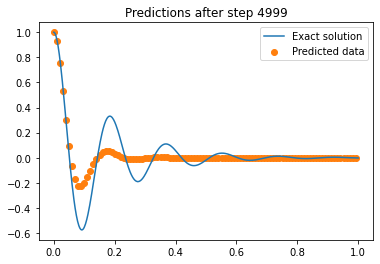

Predicted parameters: tensor([16.4947, 39.3980], grad_fn=<AddBackward0>), True parameters: [6, 34.641], Validation loss: 66.38409423828125


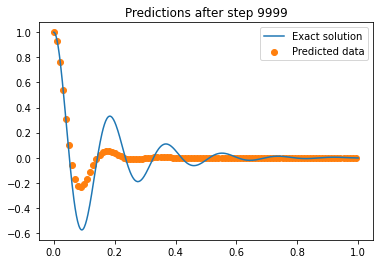

Predicted parameters: tensor([16.1730, 39.2721], grad_fn=<AddBackward0>), True parameters: [6, 34.641], Validation loss: 62.467994689941406


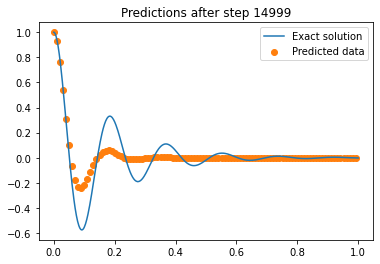

Predicted parameters: tensor([16.8332, 39.0860], grad_fn=<AddBackward0>), True parameters: [6, 34.641], Validation loss: 68.55804443359375


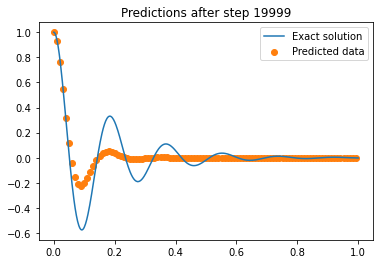

In [7]:
### Train and validate

# get_slice = lambda i, size: range(i * size, (i + 1) * size)

torch.manual_seed(123)
model = FullyConnected(100, 128, 2)
optimizer2 = torch.optim.Adam(model.parameters(), lr=1e-3)#, weight_decay=1e-4)
scheduler = StepLR(optimizer2, step_size=10000, gamma=0.95)

for i in range(20000):
  optimizer2.zero_grad()

  # parameter loss
  par_pred = model(y_train)
  par_loss = torch.mean((par_pred - par_train) ** 2) # Mean squared error

  # data loss
  # TODO

  loss = par_loss
  loss.backward()
  optimizer2.step()
  scheduler.step()

  if (i+1) % 5000 == 0:
    par_pred_val = model(y_val)
    val_loss = torch.mean((par_pred_val - par_val) ** 2) # should be only data loss
    print(f'Predicted parameters: {par_pred_val}, True parameters: {[6, round(np.sqrt(1200), 4)]}, Validation loss: {val_loss}')
    y_par_pred = oscillator(par_pred_val[0].item(), par_pred_val[1].item(), x_val).view(-1,1)
    plt.figure()
    plt.plot(x_val_full, y_val_full, label="Exact solution")
    plt.scatter(x_val, y_par_pred, color="tab:orange", label="Predicted data")
    plt.title('Predictions after step '+str(i))
    plt.legend()
    plt.show()
